In [12]:
from IPython.display import HTML
html = HTML("""
    <style>
        .backtick {
            font-style:oblique;
            font-family:"Courier New";
            font-size:15px;
        }
    </style>
""")
html

**NOTE FROM THE FUTURE (2019-Dec-16)**

<div style="background-color:sandybrown;padding-left:5px;">
    <p> This work was from when we first took the project over from Udi (it began 2019-Oct-23, but the 
        majority of it was done on 2019-Nov-01).  </p>
    <p> What this means is:
    <ol>
        <li>the assumption is Udi's data processing pipeline (which extends the first half
            of Carlos' original pipeline) works well enough</li>
        <li>therefore, Udi's final outputted data table from this pipeline can be used for analysis.  </li>
    </ol></p>
    <p> At one point, Dani and I began questioning these assumptions and started everything from scratch
        (this explains the mbh001_v3 directory in the MBH001 GitLab repo, where I will also store a copy
        of this JNB for convenience).  </p>
    <p style="padding-left:40px;"> <b>SIDE NOTE</b>: Starting from scratch was nontrivial since the full data set
        derives from about 40 tables, some of which (as we found) are not usable or valid data.  These tables
        host a few thousand variables -- again, many of which need to be understood and vetted.  I must say,
        though we originally had (harshly) questioned Carlos' methods (some of which perhaps 
        deserved it) and subsequently
        Udi's methods (many of which just built on top of Carlos'), we ultimately could not "force" 
        the data to do any better than Udi or Carlos could.  It's possible that the strategy and methods
        used by Udi and Carlos would have borne fruit if there was enough fruit to bear.  (More importantly,
        for better or worse, it's definitely possible that their methods would have been left unquestioned
        if they were able to capture some signal, independent of whether their methods were janky
        or suboptimal.)</p>   
    <p> Anyway, in this notebook, I explore methods that I had hoped would help "stabilize" the patient
        population between training, validation, and test sets. </p>
    <p> <b>MOTIVATION</b>:</p>
    <p> Basically, the first thing you will
        notice when working with this data is that it's very hard to not overfit to training. This is
        sometimes due to lack or regularization, but other times the problem can start earlier on in
        the pipeline.  For example, in a
        highly-imbalanced binary classification problem, issues like this can be due to a bad
        splitting strategy (e.g., if you have a 1% event rate, its possible that a naive splitting strategy
        will accidentally land all your events in the validation and test sets, making training
        pointless and fruitless).  Though we are doing a regression problem this motivates my major idea. </p>
    <p> <b>IDEA</b>:</p>
    <p> It is likely that a poor/naive splitting strategy can affect a
        regresion problem as well, so I adapt the concept of stratified splitting from a categorical
        target variable to a continuous target.</p>    
    <p> <b>RESULTS</b>:</p> 
        <p><ul>
            <li> Overall, it seems to help a very little bit, but does not really save the day.</li>
            <li> Importantly, what I found is that any observed performance boosts are almost always 
                due to the random seed used to split the data.  To me, this means that there is some
                opportunistic splitting that we do not understand.  That is, though stratifying on the
                continuous target variable did not prevent this issue, there must be some variable
                that does -- otherwise a random "random seed" wouldn't suddenly see a performance boost
                for no reason.  One of our goals should be to try to identify this feature, if possible. </li>
        </ul>
    </p>
    <hr>
    <p style='background-color:orange;'> 
        <b>NOTE</b>: For analyses relevant to final report sent to Gates Foundation, please
        check out notebooks <font class=backtick>01_KU</font> through 
        <font class=backtick>04_KU</font> in <font class=backtick>mbh001/mbh001_v3</font>.
    </p>
    <hr>
    <p style='color:red;background-color:yellow;margin-left:-5px'><b>NOTE</b>: This notebook is copied to 
         <font class=backtick>mbh001_v3/notebooks</font>
         where it is prefixed <font class=backtick>00c__KU</font>.</p>

</div>

--------------------------------------------------


**2019-Oct-23**

Since this project has changed hands quite a bit, I am just doing some exploratory analysis here.

# Motivation 

If you look at the model runs when we've removed patients that had "cesarian w/o labor", the R2 score on training is often double the R2 on the dev/val set. For example, for a LASSO model trained on everything but the sensor data, we saw:

```
# Clinical+Demographic Data (special patients removed from data set)
R2 train:  0.74
R2 dev: 0.25
```

For another LASSO run w/ all the data, including the sensor stuff, this effect was reduced, but
not eliminated:

```
# All Data (special patients removed from data set)
R2 train: 0.37
R2 dev: 0.24
```



This is not the case when these patients are not removed.  For example, when training a LASSO model with the clinical and demographic data, we found:

```
# Clinical+Demographic Data (special patients included)
R2 train: 0.33
R2 dev: 0.36
```


If there is anything surprising when the special patients are included, it is that R2 is higher on the dev 
set.  Otherwise, these numbers are close enough and look like what you would expect (for a model that is not over/under fit).  


## Discussion
Ok, let's think about this: R2 ("R squared" or "R-two-score") is not a great way to measure
the predictive power of a model.  I'll get to why.

R2 is often quoted as a measure of "goodness of fit." It says something about how much 
of the variance in a given data set is explained by the model on that given data set.  Everything
still sounds ok, right?  But it's not: the definition is data set dependent.  

$$
R^{2} = 1 - \frac{\sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^2}{\sum_{i=1}^{n}(y_{i}-\bar{y}_{i})^2}
$$

Notice that denominator.  It's called the "null model." It measures how well you can
predict outcomes if the only information you had was a data set representative of
the true population and an unbiased estimate of the mean.  

This should give you pause about using the R2 score to compare training and dev sets.  


### Scenario 1:  Dependence on Outcome Range
Assume that the independent variable, x, is time at a monthly interval and the
dependent variable, y, is the monthly revenue your firm has acquired.  You plot
y vs x and see that it is noisy, but there has been consistent growth month to 
month -- and much of that growth look fairly linear.  You get the idea to do
a regression to start making predictions for your boss...  The model fit
looks good on the plot, but to be sure you compute the R2 score.

About a year later, your boss asks whether the model is still working well.  So 
you re-compute the R2 score, this time using
the original data plus the new data from the past year.  What you find is
a great surprise: "The model," you tell your boss, "not only still works, but
is working better than ever before!"

Let's look at the definition of R2 again:

$$
R^{2} = 1 - \frac{\sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^2}{\sum_{i=1}^{n}(y_{i}-\bar{y}_{i})^2}
$$

Note that this can be recast in terms of mean squared error (MSE; more on this below):

$$
R^{2} = 1 - \frac{MSE_{pred}}{MSE_{null}}
$$

Here, `MSE_{pred}` is the MSE of your predictive model, while `MSE_{null}` is the MSE of the
null model.  

Let's assume that the same regression still fits the data, new and old, very
well.  In fact, let's say you know this for sure because you refit the model and
all the coefficients were more-or-less the same as before.  

However, your R2 score is bigger.  Why?

You investigate.  First, you look at `MSE_{pred}` on the original data and compare it
to its computation on all the data (original and newly collected).  You note that
it hasn't changed much.  In other words, `MSE_{pred}` appears to be fairly constant.  Well,
this leaves only one possibility: `MSE_{null}` must have grown.

Well, duh!  

Think about what happened:  monthly revenue continued to grow each month, so the range
of the data has increased.  This means that (i) there will be a new estimate of the mean, 
(ii) that outcome values will have a larger spread about this mean, (iii) that `MSE_{null}`
will in turn be a larger value than before, which (iv) means that `MSE_{pred}/MSE_{null}` will
have shrunk, which (v) means R2 will have grown.


Huge takeaway:  In this scenario, MSE remained constant over the two data sets, properly
reflecting that the model still worked well, but no better than it did previously. 



### Scenario 2:  Dependence on Range (Take 2)

In this scenario, imagine you think you're doing everything right.  For example, you split the data
into training, development, and test sets.  

You fit the model to the training set, then compute R2 on training and dev.  On training things look
great, but on dev it's not so good.  You try another type of model, but find the same thing.  You
do this several times, but continue having a discrepancy... 

What is happening?  

First thing that might come to mind is that the data was poorly split -- that the training and
dev sets do not really represent the same outcome population.  You look at the training set and
dev set means: they look about the same.  So you compute medians...again, about the same.  Then
you look at min and max.  

The dev set has a much tighter distribution than the training set.

Ah, now it all makes sense:  the tighter distribution around the same mean indicates that
$MSE_{null,dev} < MSE_{null,trn}$, which means $R^{2}_{dev} < R^{2}_{trn}$

In this scenario, you might still find comparable MSEs for the predictive model itself.

The major point thus far:  if you want to use R2 score, then the definition of R2 score
should be modified, while respecting best practices of predictive modeling.

Bad:
* compute null model on full data set (data leakage)

Good:
* compute null model on training set
* use same null model for R2 computations on training, dev, test


At least with this modified defintion of R2, we would no longer have ambiguities arise
that have nothing to do with the type of predictive power we're interested in.  It makes
more sense for predictive modeling, where the dev and test data are at various levels
of out-of-sight-out-of-mind.  The idea is that the training null model is our "baseline
bad model" that we all validate on dev and test sets.

However, the better idea is just to do what most machine learning practitioners actually
do in this case:  use RMSE instead of R2.




---------------


For 
training, you are looking at how much better a prediction you've
made than just guessing the mean of the training set.  

For dev, you  are looking at how much better a 
prediction you've made than just guessing the mean of the dev set.  

Well, this is only ok if 
the estimates of the target mean on the two sets are comparable.  This is partially why I would suspect
that the training and dev sets differ in their target distribution after we removed the patients 
having "cesarian w/o labor."  This is also why I'd argue to use MSE for a predicive model, not
R2 (which is used by statisticians building inference models without a val/dev set).


## Bla

For predictive regression models, I have more intuition using MSE.  If the MSE is much larger on the dev
set than the training set, I'd wager that the model has overfit to the training set.  Alternatively, I might
guess that the dev set differs in its target distribution (this is easy to imagine in classification models
where low frequency classes might be left out of one of the set without using stratified sampling).  

The definition of R2 score is just a linear transformation of MSE, so it should behave similarly to MSE (in a linearly transformed way).  One difference is that a bigger number (closer to 1.0) is better than a smaller
number (closer to 0.0).  

MSE: 
$$
\frac{1}{N}\sum_{i=1}^{N}(y_{i}-\hat{y}_{i})^{2}
$$

R2 Score: 
$$
R^{2} = 1 - \frac{\sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^2}{\sum_{i=1}^{n}(y_{i}-\bar{y}_{i})^2} \\
\quad = 1 - \frac{N*MSE}{(N-1)\sigma^{2}} \\
\quad\quad\quad\quad = \frac{N}{(N-1)\sigma^{2}}MSE + (-1) \\
\quad = m*MSE + b
$$





# Approach
We must first define what we mean by similar enough.  

In classification, this means we have enough of each class in train/dev/test.  

For regression, it might mean we have enough representation over each interval.  As usual, someone already came across this issue and solved it.  For example, in this blog, the author provides a small snippet of code that does the trick.  Essentially, you create a new, binned version of the continuous target variable, then stratify on the binned variable – after which, you can just throw it out.  Very simple!

```python
# Create the bins.  My `y` variable has
# 506 observations, and I want 50 bins.

bins = np.linspace(0, 506, 50)

# Save your Y values in a new ndarray,
# broken down by the bins created above.

y_binned = np.digitize(y, bins)

# Pass y_binned to the stratify argument,
# and sklearn will handle the rest

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, stratify=y_binned)

```

Before I do something like that though, I just want to look at the actual distributions between Udi’s training and dev sets.



## Other Criticisms of R2
It is well known that R2 can be a horrible way to compare different models, especially
if differing amounts of variables are used.  For example, assumes we maintain the
same model architecture, but continue adding variables: R2 will inevitably increase w/
no evidence of whether the new variables actually helped or hurt: is the model fitting to
the noise, or has a real relationship been found?   This is where a validation set becomes 
necessary -- well, from a predictive modeling perspective it's always necessary, but 
traditional statisticians did not use validation sets.  The validation set will
likely show you big differences in R2 if the model was fitting to the noise, however
due to criticisms outlined above, the change in R2 between data sets is not always
unambiguous...  Better to use adjusted R2.  Or, if caring about predictions, maybe
just use RMSE w/ both training and dev/val sets.  There is also something called predictive R2, but this is again
from a time when validation sets weren't used: its based on a leave-one-out CV 
strategy.


## Last Note
I found that John Myles White said this all more eloquently than I've spelled out:

> People sometimes use R2 as their preferred measure of model fit. Unlike quantities such as MSE or MAD, R2 is not a function only of model’s errors, its definition contains an implicit model comparison between the model being analyzed and the constant model that uses only the observed mean to make predictions. As such, R2 answers the question: “does my model perform better than a constant model?” But we often would like to answer a very different question: “does my model perform worse than the true model?”
>
> In theoretical examples, it is easy to see that the answers to these two questions are not interchangeable. We can construct examples in which our model performs no better than a constant model, even though it also performs no worse than the true model. But we can also construct examples in which our model performs much better than a constant model, even when it also performs much worse than the true model.
>
> As with all model comparisons, R2 is a function not only of the models being compared, but also a function of the data set being used to perform the comparison. For almost all models, there exist data sets that are wholly incapable of distinguishing between the constant model and the true model. In particular, when using a dataset with insufficient model-discriminating power, R2 can be pushed arbitrarily close to zero — even when we are measuring R2 for the true model. As such, we must always keep in mind that R2 does not tell us whether our model is a good approximation to the true model: R2 only tells us whether our model performs noticeably better than the constant model on our dataset.
- [Why I'm Not a Fan of R2](http://www.johnmyleswhite.com/notebook/2016/07/23/why-im-not-a-fan-of-r-squared/), J. M. White


Apparently, R2 is not really great for causal inference either...e.g., check 
[this](https://thestatsgeek.com/2014/01/25/r-squared-and-goodness-of-fit-in-linear-regression/) out.  Turns
out that, other than being a super common statistic that people think they have intuition for, it's not
all that good for anything...


https://stats.stackexchange.com/questions/214886/regression-what-is-the-utility-of-r-squared-compared-to-rmse

https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/



Here is someone who asks about R squared on the validation set:  https://www.reddit.com/r/rstats/comments/3al070/question_about_out_of_sample_rsquared/.  Basically,
the first commenter says what I consider to be wrong.  The second commenter says what I consider to
be right:  the mean should be the mean from the training set b/c you want to compare how well
your model performs in validation against how well the null model would have performed in validation.



### References
* [Sklearn's R2 Score](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score)
* [Sklearn's MSE](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)
* https://michaeljsanders.com/2017/03/24/stratify-continuous-variable.html
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4530125/
* https://data.library.virginia.edu/is-r-squared-useless/
* https://statisticsbyjim.com/regression/interpret-adjusted-r-squared-predicted-r-squared-regression/





# Preliminary Look
Here, I just use Udi's train/dev/tst split (same random seed, etc).  Then I look some distributions.

In [130]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from scipy.stats import zscore,expon
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
pd.options.display.max_rows = 20

In [204]:
# Get the Data
d = pickle.load( open( "../data/processed/mbh001_f3_toi_mon_baseline_a.p", "rb" ))

# Nullity Threshold
na_th = 0.8

# Drop High-Nullity Cols
df = d.dropna(axis=1,thresh=len(d)*na_th).copy()

# Separate X & Y Data
x = df.drop(['time_left','ga.birth'], axis=1)
y = df['time_left']

# Feature Groups
con_feat   = x.select_dtypes('float64').columns
cat_feat   = x.select_dtypes('object').columns
sensor_feat= x.filter(regex='^toi|^mon').columns

In [46]:
x[num_feat].min().min()

-483.42412224776774

In [211]:
# Since we are using RandomForest, I will NOT OHE cat vars or try
#   to "smartly" impute continuous vars.  Instead, I'll assign a
#   'NaN' category to catVars and a large, unique, negative value
#   to contVars
# NOTE: even though there are catVars, they are all numerically
#   encoded, so creating a 'null' category mixes type; instead,
#   just create a -9999 category like with continuous vars.
x.fillna(-9999, inplace=True)

### Distribution of "Time Left" for Unsplit Data

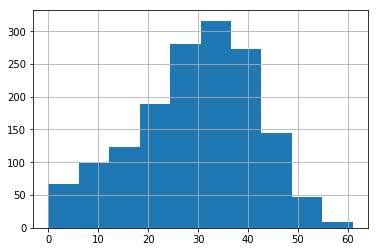

In [73]:
y.hist()

### Split the Data in trn/dev/tst

In [116]:
x_trn, x_dev, y_trn, y_dev = train_test_split(x, y, test_size=0.3, random_state=42)
x_dev, x_tst, y_dev, y_tst = train_test_split(x_dev, y_dev, test_size=0.5, random_state=42)

### Distribution of "Time Left" for Trn

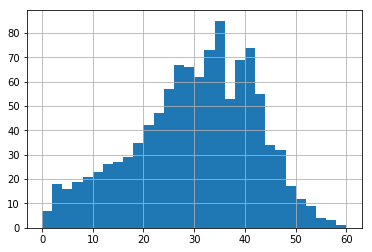

In [75]:
y_trn.hist(bins=30)

### Distribution of "Time Left" for Dev

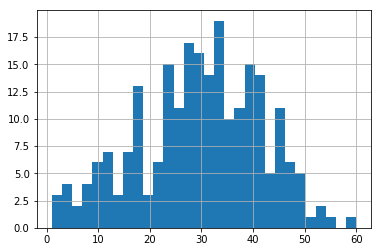

In [12]:
y_dev.hist(bins=30)

### Distribution of "Time Left" for Tst

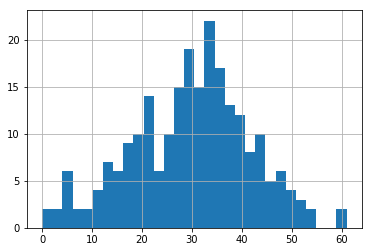

In [14]:
y_tst.hist(bins=30)

# Thoughts So Far
Well, interestingly, you can see that the training distribution is better fleshed out and
normal looking than the dev or test distributions...so maybe the stratified split will help with this,
and maybe that will help with the divergent model R2 scores.

First, so everything is in one place in this notebook, let's look at the MSEs and R2 scores for various model
runs using these un-stratified splits.

# Un-Stratified Model Metrics (Full Population)

In [161]:
x_trn, x_dev, y_trn, y_dev = train_test_split(x, y, test_size=0.3, random_state=42)
x_dev, x_tst, y_dev, y_tst = train_test_split(x_dev, y_dev, test_size=0.5, random_state=42)

In [117]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)

grid = {
    'criterion': ['mse','mae'],                  # 2
    'n_estimators': [10,100,500,1000],           # 4
    'max_features': [2, 3, 'log2','sqrt', None], # 5
    'max_depth': [3,4,8,16,32,None],             # 6
    'min_samples_split': [2,4,8,16,32,64],       # 6
    'min_samples_leaf': [1,2,5,10,30,0.1,0.2],   # 7
} # 2*4*5*6*6*7 = 1,080-model GridSearch
# Let's assume that randomly samplng 250 models is good enough
n_iter = 250
kfolds = 3

best_rf = RandomizedSearchCV(
    rf,
    grid,
    n_jobs  = -1,
    cv      = kfolds,
    n_iter  = n_iter,  # e.g., 250 models searched
    return_train_score = True,
    scoring = ['r2', 'neg_mean_absolute_error',
               'neg_mean_squared_error','neg_median_absolute_error'],
    refit   = 'neg_mean_squared_error',
    verbose=True,
)


In [118]:
best_rf.fit(x_trn,y_trn)

Fitting 3 folds for each of 250 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 15.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=250, n_jobs=-1,
          param_distributions={'criterion': ['mse', 'mae'], 'n_estimators': [10, 100, 500, 1000], 'max_features': [2, 3, 'log2', 'sqrt', None], 'max_depth': [3, 4, 8, 16, 32, None], 'min_samples_split': [2, 4, 8, 16, 32, 64], 'min_samples_leaf': [1, 2, 5, 10, 30, 0.1, 0.2]},
          pre_dispatch='2*n_jobs', random_state=None,
          refit='neg_mean_squared_error', return_train_score=True,
          scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'

In [119]:
best_rf.best_params_

{'n_estimators': 1000,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 16,
 'criterion': 'mae'}

In [162]:
y_trn_pred = best_rf.predict(x_trn)
y_dev_pred = best_rf.predict(x_dev)

print('MAE, Trn:', mean_absolute_error(y_trn, y_trn_pred))
print('MAE, Dev:', mean_absolute_error(y_dev, y_dev_pred),'\n')

print('MSE, Trn:', mean_squared_error(y_trn, y_trn_pred))
print('MSE, Dev:', mean_squared_error(y_dev, y_dev_pred),'\n')

print('R2, Trn:', r2_score(y_trn, y_trn_pred))
print('R2, Dev:', r2_score(y_dev, y_dev_pred))

MAE, Trn: 3.7806163434903044
MAE, Dev: 7.978122844827586 

MSE, Trn: 24.09238957040628
MSE, Dev: 96.91025222521553 

R2, Trn: 0.8309494827850666
R2, Dev: 0.343523784765153


### Some Thoughts
Wow, if you ask me, the model was allowed to completely overfit the training data.  Figuring CV is
used, this does make it seem like the training set and dev set must have some fundamental differences,
which stratified sampling might help.


# Stratified Model Metrics (Full Population, Test)
We'll create 5 target bins, where target ranges from 0 to 61.  

We stratify properly between training and union(dev,tst), the just split dev and tst.

We will use the parameters from the best fit model before, then do a GridSearch.

In [212]:
bins = np.linspace(0, 61, 10)
yb = np.digitize(y, bins)
x_trn, x_dev, y_trn, y_dev = train_test_split(x, y, test_size=0.3, stratify=yb, random_state=42)
x_dev, x_tst, y_dev, y_tst = train_test_split(x_dev, y_dev, test_size=0.5, random_state=42)


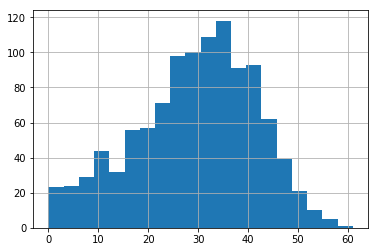

In [213]:
y_trn.hist(bins=20)

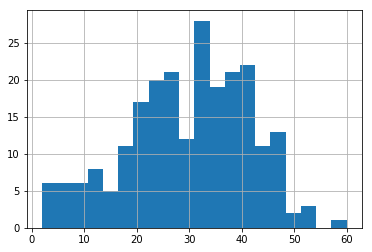

In [214]:
y_dev.hist(bins=20)

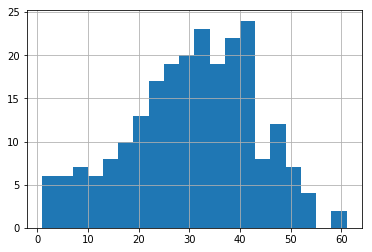

In [215]:
y_tst.hist(bins=20)

In [216]:
rfs = RandomForestRegressor(
    n_estimators = 1000,
    min_samples_split = 8,
    min_samples_leaf = 1,
    max_features = None,
    max_depth = 16,
    criterion = 'mae',
    n_jobs=-1,
)
# Crazy: note that I didn't use random state 42 here...and got great results...

In [217]:
rfs.fit(x_trn, y_trn)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=16,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [222]:
y_trn_pred = rfs.predict(x_trn)
y_dev_pred = rfs.predict(x_dev)
y_tst_pred = rfs.predict(x_tst)


print('MAE, Trn:', mean_absolute_error(y_trn, y_trn_pred))
print('MAE, Dev:', mean_absolute_error(y_dev, y_dev_pred),'\n')

print('MSE, Trn:', mean_squared_error(y_trn, y_trn_pred))
print('MSE, Dev:', mean_squared_error(y_dev, y_dev_pred),'\n')

print('R2, Trn:', r2_score(y_trn, y_trn_pred))
print('R2, Dev:', r2_score(y_dev, y_dev_pred))
print('R2, Dev:', r2_score(y_tst, y_tst_pred))

MAE, Trn: 3.7872987072945525
MAE, Dev: 7.4837521551724135 

MSE, Trn: 24.241840129501384
MSE, Dev: 91.85436157650864 

R2, Trn: 0.8276769036013358
R2, Dev: 0.31959881987449923
R2, Dev: 0.3003842692559925


# Stratified Model Metrics (Full Population, GridSearch)
For the first random gridsearch, I will maintain the same hyperparameter sets.  However,
I have some concerns...

The last time, the GridSearch turned up `max_features: None`, which literally means we no longer
have a true RF...and likely have highly correlated trees, which is bound to generalize to dev set
poorly.  Also, `max_depth: None` is potentially concerning...  Not necessarily, but some depth
regularization is likely a good thing.  To know how much, we have to look at the depths of the 
trees in the gridSearch's best RF. (Actually, we know it is 16, but I include a code snippet
that shows you how to do it in general.)

In [177]:
np.percentile([tree.max_depth for tree in best_rf.best_estimator_.estimators_], [0,25,50,75,100])

array([16., 16., 16., 16., 16.])

In [180]:
# Data Split
bins = np.linspace(0, 61, 10)
yb = np.digitize(y, bins)
x_trn, x_dev, y_trn, y_dev = train_test_split(x, y, test_size=0.3, stratify=yb, random_state=42)
x_dev, x_tst, y_dev, y_tst = train_test_split(x_dev, y_dev, test_size=0.5, random_state=42)

# Base RF
rf_strat = RandomForestRegressor(n_jobs=-1, random_state=42)

# Hyperparameter Grid
grid = {
    'criterion': ['mse','mae'],                  # 2
    'n_estimators': [10,100,500,1000],           # 4
    'max_features': [2, 3, 'log2','sqrt', None], # 5
    'max_depth': [3,4,8,16,32,None],             # 6
    'min_samples_split': [2,4,8,16,32,64],       # 6
    'min_samples_leaf': [1,2,5,10,30,0.1,0.2],   # 7
} # 2*4*5*6*6*7 = 10,080-model GridSearch
# Let's assume that randomly samplng 250 models is good enough
n_iter = 250
kfolds = 3

# GridSearch
best_rfs = RandomizedSearchCV(
    rf_strat,
    grid,
    n_jobs  = -1,
    cv      = kfolds,
    n_iter  = n_iter,  # e.g., 250 models searched
    return_train_score = True,
    scoring = ['r2', 'neg_mean_absolute_error',
               'neg_mean_squared_error','neg_median_absolute_error'],
    refit   = 'neg_mean_squared_error',
    verbose=True,
)


In [181]:
best_rfs.fit(x_trn,y_trn)
best_rfs.best_params_

Fitting 3 folds for each of 250 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 27.3min finished


{'n_estimators': 1000,
 'min_samples_split': 4,
 'min_samples_leaf': 10,
 'max_features': None,
 'max_depth': 16,
 'criterion': 'mse'}

Some interesting discrepancies between the non-stratified and stratified runs.


|  run     | n_estimators | min_samples_split | min_samples_leaf | max_features | max_depth | criterion |
|----------|--------------|-------------------|------------------|--------------|-----------|-----------|
| No Strat | 1000         | 8                 | 1                | None         | 16        | MAE       |
| W/ Strat | 1000         | 4                 | 10               | None         | 16        | MSE       |

What this tells me is:
* `n_estimators`we may not have explored enough since it always maxes out
* `min_samples_split`:  given 4 and 8, we can probably cut down some of the larger options in [2,4,8,16,32,64]
* `min_samples_leaf`: given 1 and 10, we can probably remove the larger options in [1,2,5,10,30,10%,20%]
* `max_features`: this is fairly robustly `None`, but this violates basics of RF... need to explore this more
* `max_depth`:  16 is pretty robust (at the least, we can likely leave out "None" option from next search)
* `criterion`:  just keep allowing search over both...



In [182]:
y_trn_pred = best_rfs.predict(x_trn)
y_dev_pred = best_rfs.predict(x_dev)

print('MAE, Trn:', mean_absolute_error(y_trn, y_trn_pred))
print('MAE, Dev:', mean_absolute_error(y_dev, y_dev_pred),'\n')

print('MSE, Trn:', mean_squared_error(y_trn, y_trn_pred))
print('MSE, Dev:', mean_squared_error(y_dev, y_dev_pred),'\n')

print('R2, Trn:', r2_score(y_trn, y_trn_pred))
print('R2, Dev:', r2_score(y_dev, y_dev_pred))

MAE, Trn: 5.531520855249879
MAE, Dev: 7.541420337416439 

MSE, Trn: 51.29657810071865
MSE, Dev: 93.06215468979839 

R2, Trn: 0.6353583256984559
R2, Dev: 0.31065222392058456


#### Yikes
Ok, wow...  So the GridSearch really is the problem.  It is allowing too much
overfitting of the training set.  This is likely due to allowing so many estimators
and allowing `max_features` to be the full feature set.

Explore this...

FIRST:  I'll continue to allow `n_estimators` to grow to 1k, but I am removing the
ability for `max_features` to select `None`.

In [183]:
# Data Split
bins = np.linspace(0, 61, 10)
yb = np.digitize(y, bins)
x_trn, x_dev, y_trn, y_dev = train_test_split(x, y, test_size=0.3, stratify=yb, random_state=42)
x_dev, x_tst, y_dev, y_tst = train_test_split(x_dev, y_dev, test_size=0.5, random_state=42)

# Base RF
rf_strat = RandomForestRegressor(n_jobs=-1, random_state=42)

# Hyperparameter Grid
grid = {
    'criterion': ['mse','mae'],                  # 2
    'n_estimators': [10,100,500,1000],           # 4
    'max_features': [2, 3, 'log2','sqrt'],       # 4  (removed None)
    'max_depth': [3,4,8,16,32],                  # 5  (removed None)
    'min_samples_split': [2,4,8,16],             # 4  (removed 32, 64)
    'min_samples_leaf': [1,2,5,10,30],           # 5  (removed 10%, 20%)
} # 2*4*4*5*4*5 = 3200-model GridSearch
# Let's assume that randomly samplng 250 models is good enough
n_iter = 250
kfolds = 3

# GridSearch
best_rfs = RandomizedSearchCV(
    rf_strat,
    grid,
    n_jobs  = -1,
    cv      = kfolds,
    n_iter  = n_iter,  # e.g., 250 models searched
    return_train_score = True,
    scoring = ['r2', 'neg_mean_absolute_error',
               'neg_mean_squared_error','neg_median_absolute_error'],
    refit   = 'neg_mean_squared_error',
    verbose=True,
)


In [184]:
best_rfs.fit(x_trn,y_trn)
best_rfs.best_params_

Fitting 3 folds for each of 250 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  8.5min finished


{'n_estimators': 500,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 32,
 'criterion': 'mse'}

In [185]:
y_trn_pred = best_rfs.predict(x_trn)
y_dev_pred = best_rfs.predict(x_dev)

print('MAE, Trn:', mean_absolute_error(y_trn, y_trn_pred))
print('MAE, Dev:', mean_absolute_error(y_dev, y_dev_pred),'\n')

print('MSE, Trn:', mean_squared_error(y_trn, y_trn_pred))
print('MSE, Dev:', mean_squared_error(y_dev, y_dev_pred),'\n')

print('R2, Trn:', r2_score(y_trn, y_trn_pred))
print('R2, Dev:', r2_score(y_dev, y_dev_pred))

MAE, Trn: 3.3996217273526157
MAE, Dev: 8.20697083549055 

MSE, Trn: 18.997081555847515
MSE, Dev: 109.00891833579237 

R2, Trn: 0.8649592646946918
R2, Dev: 0.19252830886970007


#### YIKES
Again, we see MAJOR OVERFITTING.... Serious, disgusting, uh-oh overfitting...

|  run                 | n_estimators | min_samples_split | min_samples_leaf | max_features | max_depth | criterion |
|----------------------|--------------|-------------------|------------------|--------------|-----------|-----------|
| No Strat             | 1000         | 8                 | 1                | None         | 16        | MAE       |
| W/ Strat (full hp)   | 1000         | 4                 | 10               | None         | 16        | MSE       | 
| W/ Strat (reduced hp)| 500          | 4                 | 1                | sqrt         | 32        | MSE       |

Interestingly, the overfitting is still huge...yet it selected less estimators.

NEXT:
* allow estimators to only get up to 100 (add in a few sub-100 possibility, e.g., 25,50,75)
* take away option for terminal purity (1/leaf), which is likely noise fitting (maybe even take away 2/leaf)
* if min sample per leaf is 4, then adjust `min_samples_split` accordingly (4 is lowest)
* use 5 CV folds...

In [186]:
# Data Split
bins = np.linspace(0, 61, 10)
yb = np.digitize(y, bins)
x_trn, x_dev, y_trn, y_dev = train_test_split(x, y, test_size=0.3, stratify=yb, random_state=42)
x_dev, x_tst, y_dev, y_tst = train_test_split(x_dev, y_dev, test_size=0.5, random_state=42)

# Base RF
rf_strat = RandomForestRegressor(n_jobs=-1, random_state=42)

# Hyperparameter Grid
grid = {
    'criterion': ['mse','mae'],                  # 2
    'n_estimators': [10,25,50,75,100],           # 5  (removed 1k, 500; added 25,50,75)
    'max_features': [2, 3, 'log2','sqrt'],       # 4  (removed None)
    'max_depth': [3,4,8,16,32],                  # 5  (removed None)
    'min_samples_split': [4,8,16],               # 3  (removed 32, 64; removed 2)
    'min_samples_leaf': [4,8,16,32],             # 4  (removed 10%, 20%; removed 1, 2)
} # 2*5*4*5*3*4 = 2400-model GridSearch
# Let's assume that randomly samplng 250 models is good enough
n_iter = 250
kfolds = 5

# GridSearch
best_rfs = RandomizedSearchCV(
    rf_strat,
    grid,
    n_jobs  = -1,
    cv      = kfolds,
    n_iter  = n_iter,  # e.g., 250 models searched
    return_train_score = True,
    scoring = ['r2', 'neg_mean_absolute_error',
               'neg_mean_squared_error','neg_median_absolute_error'],
    refit   = 'neg_mean_squared_error',
    verbose=True,
)

best_rfs.fit(x_trn,y_trn)
best_rfs.best_params_

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  3.5min finished
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 75,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 16,
 'criterion': 'mae'}

In [187]:
y_trn_pred = best_rfs.predict(x_trn)
y_dev_pred = best_rfs.predict(x_dev)

print('MAE, Trn:', mean_absolute_error(y_trn, y_trn_pred))
print('MAE, Dev:', mean_absolute_error(y_dev, y_dev_pred),'\n')

print('MSE, Trn:', mean_squared_error(y_trn, y_trn_pred))
print('MSE, Dev:', mean_squared_error(y_dev, y_dev_pred),'\n')

print('R2, Trn:', r2_score(y_trn, y_trn_pred))
print('R2, Dev:', r2_score(y_dev, y_dev_pred))

MAE, Trn: 5.645607879347491
MAE, Dev: 8.248563218390805 

MSE, Trn: 54.87699201805683
MSE, Dev: 109.77829042145595 

R2, Trn: 0.609906956935664
R2, Dev: 0.18682926893238483


#### YIKES
Wow... It's still so bad.  Grid searches are fucking shitty...  Everyone talks about
grid searching, and it seems to work on simple data sets... But here, even w/ 5-fold CV,
we can't help but overfit the training set.....

We need better regularization yet again....

What's weird is:  why did the model work so well on my first try?  That's scary and hopefully
I didn't get excited prematurely...

|  run                 | n_estimators | min_samples_split | min_samples_leaf | max_features | max_depth | criterion |
|----------------------|--------------|-------------------|------------------|--------------|-----------|-----------|
| No Strat             | 1000         | 8                 | 1                | None         | 16        | MAE       |
| W/ Strat (full hp)   | 1000         | 4                 | 10               | None         | 16        | MSE       | 
| W/ Strat (reduced hp)| 500          | 4                 | 1                | sqrt         | 32        | MSE       |
| W/ Strat (rhp*)      | 75           | 4                 | 4                | sqrt         | 16        | MAE       |

NEXT:
* further reduce terminal purity 
* adjust `min_samples_split` accordingly
* use 5 CV folds...

In [192]:
# Data Split
bins = np.linspace(0, 61, 10)
yb = np.digitize(y, bins)
x_trn, x_dev, y_trn, y_dev = train_test_split(x, y, test_size=0.3, stratify=yb, random_state=42)
x_dev, x_tst, y_dev, y_tst = train_test_split(x_dev, y_dev, test_size=0.5, random_state=42)

# Base RF
rf_strat = RandomForestRegressor(n_jobs=-1, random_state=42)

# Hyperparameter Grid
grid = {
    'criterion': ['mse','mae'],                  # 2
    'n_estimators': [10,25,50,75,100],           # 5  (removed 1k, 500; added 25,50,75)
    'max_features': [2, 3, 'log2','sqrt'],       # 4  (removed None)
    'max_depth': [3,4,8,16,32],                  # 5  (removed None)
    'min_samples_split': [8,16],                 # 2  (removed 32, 64; rem 2; rem 4)
    'min_samples_leaf': [8,16,32],               # 3  (removed 10%, 20%; rem 1, 2; rem 4)
} # 2*5*4*5*2*3 = 1200-model GridSearch
# Let's assume that randomly samplng 250 models is good enough
n_iter = 300
kfolds = 5

# GridSearch
best_rfs = RandomizedSearchCV(
    rf_strat,
    grid,
    n_jobs  = -1,
    cv      = kfolds,
    n_iter  = n_iter,  # e.g., 250 models searched
    return_train_score = True,
    scoring = ['r2', 'neg_mean_absolute_error',
               'neg_mean_squared_error','neg_median_absolute_error'],
    refit   = 'neg_mean_squared_error',
    verbose=True,
)

best_rfs.fit(x_trn,y_trn)
best_rfs.best_params_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  4.1min finished
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 75,
 'min_samples_split': 16,
 'min_samples_leaf': 8,
 'max_features': 'sqrt',
 'max_depth': 32,
 'criterion': 'mae'}

In [193]:
y_trn_pred = best_rfs.predict(x_trn)
y_dev_pred = best_rfs.predict(x_dev)

print('MAE, Trn:', mean_absolute_error(y_trn, y_trn_pred))
print('MAE, Dev:', mean_absolute_error(y_dev, y_dev_pred),'\n')

print('MSE, Trn:', mean_squared_error(y_trn, y_trn_pred))
print('MSE, Dev:', mean_squared_error(y_dev, y_dev_pred),'\n')

print('R2, Trn:', r2_score(y_trn, y_trn_pred))
print('R2, Dev:', r2_score(y_dev, y_dev_pred))

MAE, Trn: 6.628224068944291
MAE, Dev: 8.181379310344827 

MSE, Trn: 75.03606824664
MSE, Dev: 107.01126896551723 

R2, Trn: 0.46660618365737705
R2, Dev: 0.20732567902920018


#### Geez
Now we're running into a new problem: the model is sucking on the training set too....so we
are underfitting.......

|  run                 | n_estimators | min_samples_split | min_samples_leaf | max_features | max_depth | criterion |
|----------------------|--------------|-------------------|------------------|--------------|-----------|-----------|
| No Strat             | 1000         | 8                 | 1                | None         | 16        | MAE       |
| W/ Strat (full hp)   | 1000         | 4                 | 10               | None         | 16        | MSE       | 
| W/ Strat (reduced hp)| 500          | 4                 | 1                | sqrt         | 32        | MSE       |
| W/ Strat (rhp*)      | 75           | 4                 | 4                | sqrt         | 16        | MAE       |
| W/ Strat (rhp**)     | 75           | 16                | 8                | sqrt         | 32        | MAE       |

NEXT:
* maybe we should allow depth to grow again?
    - but that doesn't make too much sense: no matter the model, it always seems to
      cap depth at 16 or 32

In [194]:
# Data Split
bins = np.linspace(0, 61, 10)
yb = np.digitize(y, bins)
x_trn, x_dev, y_trn, y_dev = train_test_split(x, y, test_size=0.3, stratify=yb, random_state=42)
x_dev, x_tst, y_dev, y_tst = train_test_split(x_dev, y_dev, test_size=0.5, random_state=42)

# Base RF
rf_strat = RandomForestRegressor(n_jobs=-1, random_state=42)

# Hyperparameter Grid
grid = {
    'criterion': ['mse','mae'],                  # 2
    'n_estimators': [75,150,300,600],            # 4  (removed 1k, 500; added 25,50,75)
    'max_features': [2, 3, 'log2','sqrt'],       # 4  (removed None)
    'max_depth': [3,4,8,16,32],                  # 5  (removed None)
    'min_samples_split': [8,16],                 # 2  (removed 32, 64; rem 2; rem 4)
    'min_samples_leaf': [4,8,16,32],             # 4  (removed 10%, 20%; rem 1, 2; rem 4)
} # 2*5*4*5*2*4 = 1600-model GridSearch
# Let's assume that randomly samplng 400 models is good enough
n_iter = 400
kfolds = 5

# GridSearch
best_rfs = RandomizedSearchCV(
    rf_strat,
    grid,
    n_jobs  = -1,
    cv      = kfolds,
    n_iter  = n_iter,  # e.g., 250 models searched
    return_train_score = True,
    scoring = ['r2', 'neg_mean_absolute_error',
               'neg_mean_squared_error','neg_median_absolute_error'],
    refit   = 'neg_mean_squared_error',
    verbose=True,
)

best_rfs.fit(x_trn,y_trn)
best_rfs.best_params_

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 16.1min finished
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 300,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 16,
 'criterion': 'mae'}

In [195]:
y_trn_pred = best_rfs.predict(x_trn)
y_dev_pred = best_rfs.predict(x_dev)

print('MAE, Trn:', mean_absolute_error(y_trn, y_trn_pred))
print('MAE, Dev:', mean_absolute_error(y_dev, y_dev_pred),'\n')

print('MSE, Trn:', mean_squared_error(y_trn, y_trn_pred))
print('MSE, Dev:', mean_squared_error(y_dev, y_dev_pred),'\n')

print('R2, Trn:', r2_score(y_trn, y_trn_pred))
print('R2, Dev:', r2_score(y_dev, y_dev_pred))

MAE, Trn: 5.634903047091413
MAE, Dev: 8.206163793103448 

MSE, Trn: 54.4257994716323
MSE, Dev: 107.79785174808431 

R2, Trn: 0.6131142587022183
R2, Dev: 0.20149915272887575


In [ ]:
# SANITY CHECK

In [196]:
rfz = RandomForestRegressor(
    n_estimators = 300,
    min_samples_split = 8,
    min_samples_leaf = 4,
    max_features = 'sqrt',
    max_depth = 16,
    criterion = 'mae',
    random_state= 42
)
rfz.fit(x_trn, y_trn)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=16,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [197]:
y_trn_pred = rfz.predict(x_trn)
y_dev_pred = rfz.predict(x_dev)

print('MAE, Trn:', mean_absolute_error(y_trn, y_trn_pred))
print('MAE, Dev:', mean_absolute_error(y_dev, y_dev_pred),'\n')

print('MSE, Trn:', mean_squared_error(y_trn, y_trn_pred))
print('MSE, Dev:', mean_squared_error(y_dev, y_dev_pred),'\n')

print('R2, Trn:', r2_score(y_trn, y_trn_pred))
print('R2, Dev:', r2_score(y_dev, y_dev_pred))

MAE, Trn: 5.634903047091413
MAE, Dev: 8.206163793103448 

MSE, Trn: 54.4257994716323
MSE, Dev: 107.79785174808431 

R2, Trn: 0.6131142587022183
R2, Dev: 0.20149915272887575


In [198]:
# NOW W/O RS42
rfz = RandomForestRegressor(
    n_estimators = 300,
    min_samples_split = 8,
    min_samples_leaf = 4,
    max_features = 'sqrt',
    max_depth = 16,
    criterion = 'mae',
)
rfz.fit(x_trn, y_trn)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=16,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [199]:
y_trn_pred = rfz.predict(x_trn)
y_dev_pred = rfz.predict(x_dev)

print('MAE, Trn:', mean_absolute_error(y_trn, y_trn_pred))
print('MAE, Dev:', mean_absolute_error(y_dev, y_dev_pred),'\n')

print('MSE, Trn:', mean_squared_error(y_trn, y_trn_pred))
print('MSE, Dev:', mean_squared_error(y_dev, y_dev_pred),'\n')

print('R2, Trn:', r2_score(y_trn, y_trn_pred))
print('R2, Dev:', r2_score(y_dev, y_dev_pred))

MAE, Trn: 5.674893813481071
MAE, Dev: 8.275495689655171 

MSE, Trn: 55.147870236996
MSE, Dev: 109.3792294420498 

R2, Trn: 0.6079814193863198
R2, Dev: 0.1897852696782375


In [200]:
# NOW W/O RS42 & criterion->MSE
rfz = RandomForestRegressor(
    n_estimators = 300,
    min_samples_split = 8,
    min_samples_leaf = 4,
    max_features = 'sqrt',
    max_depth = 16,
    criterion = 'mse',
)
rfz.fit(x_trn, y_trn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [201]:
y_trn_pred = rfz.predict(x_trn)
y_dev_pred = rfz.predict(x_dev)

print('MAE, Trn:', mean_absolute_error(y_trn, y_trn_pred))
print('MAE, Dev:', mean_absolute_error(y_dev, y_dev_pred),'\n')

print('MSE, Trn:', mean_squared_error(y_trn, y_trn_pred))
print('MSE, Dev:', mean_squared_error(y_dev, y_dev_pred),'\n')

print('R2, Trn:', r2_score(y_trn, y_trn_pred))
print('R2, Dev:', r2_score(y_dev, y_dev_pred))

MAE, Trn: 5.233870293948408
MAE, Dev: 8.263820484164306 

MSE, Trn: 45.085618862364385
MSE, Dev: 109.97873962191274 

R2, Trn: 0.6795089232538202
R2, Dev: 0.18534446330960108


# Question:  can I even replicate the good results from before?


In [253]:
bins = np.linspace(0, 61, 10)
yb = np.digitize(y, bins)
x_trn, x_dev, y_trn, y_dev = train_test_split(x, y, test_size=0.3, stratify=yb, random_state=42)
x_dev, x_tst, y_dev, y_tst = train_test_split(x_dev, y_dev, test_size=0.5, random_state=42)

rfs = RandomForestRegressor(
    n_estimators = 1000,
    min_samples_split = 8,
    min_samples_leaf = 1,
    max_features = None,
    max_depth = 16,
    criterion = 'mae',
    n_jobs=-1,
)
# Crazy: note that I didn't use random state 42 here...and got great results...

rfs.fit(x_trn, y_trn)

y_trn_pred = rfs.predict(x_trn)
y_dev_pred = rfs.predict(x_dev)

print('MAE, Trn:', mean_absolute_error(y_trn, y_trn_pred))
print('MAE, Dev:', mean_absolute_error(y_dev, y_dev_pred),'\n')

print('MSE, Trn:', mean_squared_error(y_trn, y_trn_pred))
print('MSE, Dev:', mean_squared_error(y_dev, y_dev_pred),'\n')

print('R2, Trn:', r2_score(y_trn, y_trn_pred))
print('R2, Dev:', r2_score(y_dev, y_dev_pred))

MAE, Trn: 3.7923079409048936
MAE, Dev: 7.530265086206896 

MSE, Trn: 24.189438289704523
MSE, Dev: 93.50718946443965 

R2, Trn: 0.8280494020273028
R2, Dev: 0.30735567729323054


In [223]:
###########################################################

In [224]:
#########################################################

In [282]:
bins = np.linspace(0, 61, 20)
yb = np.digitize(y, bins)
x_trn, x_dev, y_trn, y_dev = train_test_split(x, y, test_size=0.3, stratify=yb, random_state=37)
#x_trn, x_dev, y_trn, y_dev = train_test_split(x, y, test_size=0.3, random_state=37)

#x_dev, x_tst, y_dev, y_tst = train_test_split(x_dev, y_dev, test_size=0.5, random_state=23)

# I changed max_features to sqrt here
rfs = RandomForestRegressor(
    n_estimators = 5000,
    #min_samples_split = 16,
    min_samples_leaf = 1,
    max_features = 'sqrt',
    max_depth = 8,
    criterion = 'mse',
    n_jobs=-1,
)
# Crazy: note that I didn't use random state 42 here...and got great results...

rfs.fit(x_trn, y_trn)

y_trn_pred = rfs.predict(x_trn)
y_dev_pred = rfs.predict(x_dev)

print('MAE, Trn:', mean_absolute_error(y_trn, y_trn_pred))
print('MAE, Dev:', mean_absolute_error(y_dev, y_dev_pred),'\n')

print('MSE, Trn:', mean_squared_error(y_trn, y_trn_pred))
print('MSE, Dev:', mean_squared_error(y_dev, y_dev_pred),'\n')

print('R2, Trn:', r2_score(y_trn, y_trn_pred))
print('R2, Dev:', r2_score(y_dev, y_dev_pred))

MAE, Trn: 6.332746352004538
MAE, Dev: 8.513622287019183 

MSE, Trn: 61.14664143182258
MSE, Dev: 113.6974537476489 

R2, Trn: 0.5704851040440035
R2, Dev: 0.201128653903908


In [284]:
from sklearn.linear_model import LinearRegression

In [286]:
bins = np.linspace(0, 61, 20)
yb = np.digitize(y, bins)
x_trn, x_dev, y_trn, y_dev = train_test_split(x, y, test_size=0.3, stratify=yb, random_state=37)
#x_trn, x_dev, y_trn, y_dev = train_test_split(x, y, test_size=0.3, random_state=37)

#x_dev, x_tst, y_dev, y_tst = train_test_split(x_dev, y_dev, test_size=0.5, random_state=23)

# I changed max_features to sqrt here
rfs = RandomForestRegressor(
    n_estimators = 5000,
    #min_samples_split = 16,
    min_samples_leaf = 1,
    max_features = 'sqrt',
    max_depth = 8,
    criterion = 'mse',
    n_jobs=-1,
)
# Crazy: note that I didn't use random state 42 here...and got great results...

rfs.fit(x_trn, y_trn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Sanity Check...

In [287]:
y_trn_rfs_pred = rfs.predict(x_trn)

lr = LinearRegression()
lr.fit(y_trn_rfs_pred.reshape(-1,1), y_trn)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [290]:
y_dev_pred = lr.predict(rfs.predict(x_dev).reshape(-1,1))

#print('MAE, Trn:', mean_absolute_error(y_trn, y_trn_pred))
print('MAE, Dev:', mean_absolute_error(y_dev, y_dev_pred),'\n')

#print('MSE, Trn:', mean_squared_error(y_trn, y_trn_pred))
print('MSE, Dev:', mean_squared_error(y_dev, y_dev_pred),'\n')

#print('R2, Trn:', r2_score(y_trn, y_trn_pred))
print('R2, Dev:', r2_score(y_dev, y_dev_pred))

MAE, Dev: 8.132628395412109 

MSE, Dev: 104.82073340700845 

R2, Dev: 0.26349907024748986


In [291]:
rfs2 = RandomForestRegressor(
    n_estimators = 100,
    #min_samples_split = 16,
    min_samples_leaf = 1,
    max_features = 'sqrt',
    max_depth = 8,
    criterion = 'mse',
    n_jobs=-1,
)
rfs2.fit(y_trn_rfs_pred.reshape(-1,1), y_trn)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [292]:
y_dev_pred = rfs2.predict(rfs.predict(x_dev).reshape(-1,1))

#print('MAE, Trn:', mean_absolute_error(y_trn, y_trn_pred))
print('MAE, Dev:', mean_absolute_error(y_dev, y_dev_pred),'\n')

#print('MSE, Trn:', mean_squared_error(y_trn, y_trn_pred))
print('MSE, Dev:', mean_squared_error(y_dev, y_dev_pred),'\n')

#print('R2, Trn:', r2_score(y_trn, y_trn_pred))
print('R2, Dev:', r2_score(y_dev, y_dev_pred))

MAE, Dev: 8.128229188468467 

MSE, Dev: 108.83975909684959 

R2, Dev: 0.23526022797786195
